# A Simple Step Counting Algorithm 

In this part, we will work with five traces of real accelerometer data, collected from Pixel 3 phone, to implement a simple step counting algorithm we talked about during class. The key goal is to give you some practices of working with sensor data, applying denosing methods, and extracting useful information. There are a total of four tasks, each with its own deliverables as specified below. At the end of this assignment, you will complete a simple step detection algorithm. Part of the learning is to understand the impact of the parameters on the information extraction efficiency, so try to play around with key parameters to get the step detection results as close as possible to the ground truth. 



## Step 0: Prepartion

### Installing dependencies
We will need to install the following packages before we can import them below. Here we assume that you have already created a virtual environment and activated it.

In [4]:
!pip3 install numpy pandas matplotlib scipy

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

Below we provide a function that can load the accelerometer data and convert the timestamp to human readable format. You are free to use it or write your own.

In [6]:
def load_accelerometer_data(file_path):
    # Load the dataset
    # Replace 'file_path' with the actual path to your accelerometer dataset
    data = pd.read_csv(file_path, header=0, names=['timestamp', 'x', 'y', 'z'])

    # Since we won't be using this function anywhere else, we will nest it here. 
    def convert_timestamp(data):
        """
        Convert the timestamp to datetime format and set the correct timezone.
        """
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
        data['timestamp'] = data['timestamp'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
        return data
    def analyze_accelerometer_data(data):        
        # Calculate the number of samples
        num_samples = data.shape[0]
        
        # Calculate the sampling rate
        time_differences = data['timestamp'].diff().dropna()  # Time differences between consecutive samples
        average_sampling_interval = time_differences.mean()  # Average time interval in milliseconds
        sampling_rate = 1000 / average_sampling_interval if average_sampling_interval > 0 else float('inf')  # Convert interval to Hz
        
        return num_samples, sampling_rate
    
    
    num_samples, sampling_rate = analyze_accelerometer_data(data)
    print(f"Number of samples: {num_samples}")
    print(f"Sampling rate: {sampling_rate:.2f} Hz")
    
    data = convert_timestamp(data)

    return data, sampling_rate 

accelerometer_file = 'data/D5_lefthand_slow_circle_hop_20steps_linearaccelerometer.csv'
data, sampling_rate = load_accelerometer_data(accelerometer_file)
data.head()

Number of samples: 796
Sampling rate: 34.95 Hz


,timestamp,x,y,z
0,2024-12-30 15:08:55.580000-05:00,0.209,-0.174,0.574
1,2024-12-30 15:08:55.610000-05:00,0.203,-0.358,0.766
2,2024-12-30 15:08:55.649000-05:00,-0.069,-0.279,-0.241
3,2024-12-30 15:08:55.864000-05:00,-0.183,-0.309,-0.335
4,2024-12-30 15:08:55.889000-05:00,0.303,-0.348,-0.042


## Task 1: visualizing acceleration data 

In this first task, we will work with two real acceleration traces captured from a mobile device. Specifically, we will visualize the acceleration data along each of the three axes on a single figure to get a sense of how noisy they can be. 


For this task, you need to do the following: 
1. Write a function to plot the raw acceleration data.
2. Generate two plots, one for `data/D1_lefthand_normal_20steps.csv` and the other for `data/D3_righthand_normal_20steps_linearaccelerometer.csv`. An example plot is shown below for the fifth trace D5.
3. Answer the following questions. Based on your observation, and the official Andorid documentation on [sensor](https://developer.android.com/develop/sensors-and-location/sensors/sensors_motion#sensors-motion-accel) here:
    1. What are the value ranges for the D1 trace and the D3 trace? 
    2. Why do you think the raw accelerometer data reading look different, given that they were collected under very similar conditions?

<img src="figures/raw_acceleration_data.png" width=800>

Number of samples: 8663
Sampling rate: 400.43 Hz
Number of samples: 610
Sampling rate: 36.36 Hz


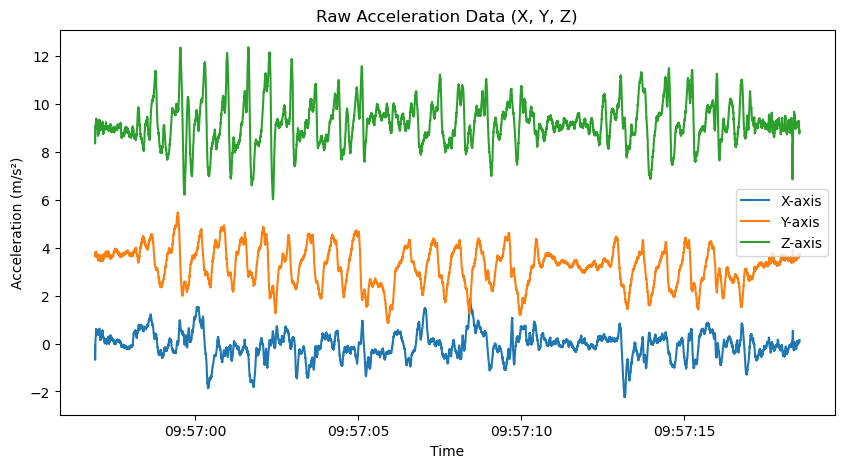

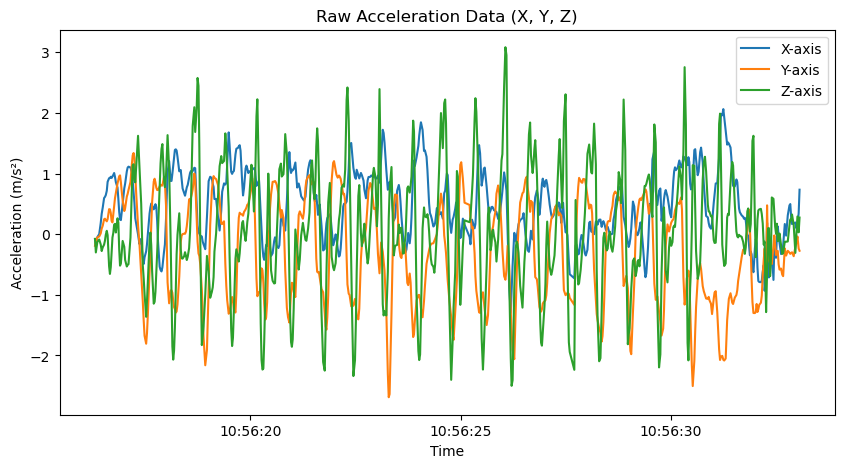

In [8]:
def plot_raw_acceleration(data, title="Raw Acceleration Data"):
    plt.figure(figsize=(10, 5))
    plt.plot(data['timestamp'], data['x'], label='X-axis')
    plt.plot(data['timestamp'], data['y'], label='Y-axis')
    plt.plot(data['timestamp'], data['z'], label='Z-axis')
    plt.xlabel("Time")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(title)
    plt.legend()
    plt.show()
 
d1 = "data/D1_lefthand_normal_20steps.csv"
d3 = "data/D3_righthand_normal_20steps_linearaccelerometer.csv"
 
data1, _ = load_accelerometer_data(d1)
data3, _ = load_accelerometer_data(d3)

plot_raw_acceleration(data1, title="Raw Acceleration Data (X, Y, Z)")
plot_raw_acceleration(data3, title="Raw Acceleration Data (X, Y, Z)")

In [10]:
print("D1 range:")
print(data1[['x', 'y', 'z']].min())
print(data1[['x', 'y', 'z']].max())

print("\nD3 range:")
print(data3[['x', 'y', 'z']].min())
print(data3[['x', 'y', 'z']].max())

D1 range:
x   -2.243
y    0.856
z    6.018
dtype: float64
x     1.889
y     5.471
z    12.371
dtype: float64

D3 range:
x   -1.298
y   -2.689
z   -2.501
dtype: float64
x    2.063
y    1.339
z    3.084
dtype: float64


## Task 2: visualize the magnitude of acceleration

As we talked about in class, holding the phone in different orientations will lead to different x, y, z patterns as we saw above. To remove the impact of orientation, we will convert the acceleration data to the magnitude of acceleration. This is an easy way to design an orientation-independent algorithm for step detections. 

For this task, you need to do the following: 
1. Plot the magnitude of acceleration for traces D1 and D3. An example figure for the D5 trace is provided below.
2. Compare the magnitude plots with the previous raw acceleration data plots, and briefly explain why it should be easier to work with the magnitude data.

<img src="figures/magnitude_data.png" width=800>

In [ ]:
def plot_magnitude_acceleration(data, title="Acceleration Magnitude Over Time"):
    
    plt.figure(figsize=(10, 5))
    plt.plot(data['timestamp'], data['x'], label='X-axis')
    plt.plot(data['timestamp'], data['y'], label='Y-axis')
    plt.plot(data['timestamp'], data['z'], label='Z-axis')
    plt.xlabel("Time")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(title)
    plt.legend()
    plt.show()
 
d1 = "data/D1_lefthand_normal_20steps.csv"
d3 = "data/D3_righthand_normal_20steps_linearaccelerometer.csv"
 
data1, _ = load_accelerometer_data(d1)
data3, _ = load_accelerometer_data(d3)

plot_raw_acceleration(data1, title="Raw Acceleration Data (X, Y, Z)")
plot_raw_acceleration(data3, title="Raw Acceleration Data (X, Y, Z)")

## Task 3: denoising the magnitude data

If we try to directly work on the raw magnitude data, we will find that the step detection algorithm result can be very off. To make it easy to work with the snesor data, it is a common practice to denoise the data. 

In this task, we will practice how to denoise the data by using a frequncy domain filter and a time domain filter. Specifically, we will use a frequency domain filter called a [butterworth filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) to remove noise. A Butterworth filter is a popular frequency domain lowpass filter that can remove high frequency noise while only letting the low frequencies through. In this task, we will use the Butterworth filter to construct a bandpass filter to only let through walking signal between 0.5Hz to 5Hz. We provide a code snippet for this filter below which you are free to use. 

```python
# TODO: configure the filter
# you will need to adjust it based on the trace your understanding from reading the documentation linked above
order = 5 
sampling_rate = 50.0 
low_cutoff = 1 
high_cuttoff = 2 

# create the filter 
nyquist = 0.5 * sampling_rate
low = low_cutoff / nyquist
high = high_cutoff / nyquist
b, a = butter(order, [low, high], btype='band', analog=False)

# apply the filter on the data 
y = filtfilt(b, a, data)
```

For the time-domain filter, we will implement an expoential moving average filter. There are two key parameters to think about. The first is the window size and the second is the decaying factor.   
- Window size: The window size determines how much smoothing is performed on the signal. As you increase the smoothing window, the signal will look cleaner and more visually pleasing, but beware of using too large a window since you will smooth out the important characteristics of the signal (for example, steps if you want to do step detection). Try increasing window size and see the effect.

- Weights: Different averaging filters give different amounts of weight to the set of values that are aveeraged. The exponentially weighted moving average filter gives exponentially decreasing weights as the observation get older (i.e. recent observations are given relatively more weight than the older observations). This value is referred to as $\alpha$ and commonly, alpha = 2 / (window_size + 1).


For this task, you need to do the following:
1. Create the bandpass filter and apply it to the raw magnitude data. 
2. Plot the filtered signal. An example figure for the D5 trace is provided below.
3. Create the exponential moving average filter and apply it to the bandpass filtered data. If you are working with pandas, you can use the built-in [ewm](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html) method.
4. Plot the expoentially weighted smoothed signal. An example figure for the D5 trace is provided below.


<img src="figures/bandpass_magnitude_data.png" width=800>

<img src="figures/exponeitally_smoothed_bandpass_magnitude_data.png" width=800>


## Task 4: Step counting on filtered magnitude data

From the filtered signal, determine the number of steps taken by the person. You can use one of the methods discussed in class or implement your own algorithm to do so. Plot the filtered signal and the detected steps.

If you want to use the [`find_peaks` method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) for step detection, here are some useful information to know.

The important parameters for this method are height, distance, prominence, and width, which you will need to properly set based on the signal.

- Height: This threshold ensures only peaks exceeding a certain value are detected, helping to filter out minor fluctuations and zeroing in on significant movements.

- Prominence: Useful in discerning genuine peaks from mere noise. A heightened prominence value ensures only peaks distinctly pronounced from their surroundings are identified. This precision is important for sidestepping minor data disturbances being misconceived as steps.

- Distance: Crucial for step detection, the distance parameter corresponds to our understanding of the time lapse between two successive steps. For example, during regular walking, we usually register 1-2 steps every second. Adjusting the distance parameter helps in preventing the recognition of multiple peaks within a single step’s duration.

- Width: The width parameter captures the full width of a peak at its half-prominence. This becomes particularly relevant in discerning between short spikes (possibly noise or artifacts) and genuine peaks of activity, like steps. In our context, width can reflect the typical duration of a step, and filtering peaks based on this duration can improve accuracy.

For this task, answer the following questions:
1. Report the number of steps detected for the D1 and D3 traces. 
2. Plot the signal and mark the points where your algorithm detects steps.  An example figure for the D5 trace is provided below.
3. Run the code snippet below to generate the results for your step detection algorithm on all five traces. The output should be similar to the following. 

```text
Total Step Count: 17
        ID      Actual    Detected     Passed?
         1          20          20        True
         2          20          17       False
         3          20          20        True
         4          20          20        True
         5          20          17       False
```


<img src="figures/step_detection_result.png" width=800>


In [ ]:
import glob, re 
directory_path = "data"
files = sorted(glob.glob(f"{directory_path}/D*"))

results = []
test_pass = False  

for f in files:

    #TODO: you will need to put everything together inside this step_detection_algorithm method
    # which takes the raw data file, and return the number of detected steps
    num_steps = step_detection_algorithm(f)
    
    # Parse filename to extract ID
    match = re.search(r'D(\d+)', f)
    id = match.group(1)
    
    # Get ground truth
    actual_steps = 20
        
    # Calculate accuracy       
    if abs(num_steps - actual_steps) <=1:
        test_pass = True
    else: 
        test_pass = False 

    # Store results 
    results.append([id, actual_steps, num_steps, test_pass])
    
# Print table   
print("{:>10}  {:>10}  {:>10}  {:>10}".format('ID', 'Actual', 'Detected', 'Passed?'))
for row in results:
    print("{:>10}  {:>10}  {:>10}  {:>10}".format(row[0], row[1], row[2], str(row[3])))